In [1]:
# loading libraries
# for first look
import requests
import pandas as pd

#train and test
from sklearn.model_selection import train_test_split

# for tags
import ast
from collections import Counter
import matplotlib.pyplot as plt
from sklearn import preprocessing

import numpy as np
from tqdm import tqdm

# svm
import pickle
from sklearn import svm
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
# NN
import copy
import torch
import torch.nn as nn
import torch.optim as optim

#test data
import joblib
import random
import time

tqdm.pandas()

# First look

In [2]:
# loading the data
url = 'https://raw.githubusercontent.com/lluisg/TechnicalTaskDigitalGenius/main/technical_test_data.json'
response = requests.get(url)

json_data = response.json()
df = pd.DataFrame.from_dict(json_data)

### First look at the table

In [3]:
# see the shape
df.shape

(1433, 22)

In [4]:
# see the names of the columns
df.columns

Index(['Description', 'association_type', 'cc_emails', 'company_id',
       'created_at', 'email_config_id', 'fr_escalated', 'fwd_emails',
       'group_id', 'id', 'priority', 'reply_cc_emails', 'requester_id',
       'responder_id', 'source', 'spam', 'status', 'subject', 'support_email',
       'tags', 'ticket_cc_emails', 'to_emails'],
      dtype='object')

In [5]:
# set the first columns as the index of the datafram
df = df.set_index(['id'])

In [6]:
# see the types of each column
df.dtypes

Description         object
association_type    object
cc_emails           object
company_id          object
created_at           int64
email_config_id      int64
fr_escalated        object
fwd_emails          object
group_id             int64
priority             int64
reply_cc_emails     object
requester_id         int64
responder_id         int64
source               int64
spam                object
status               int64
subject             object
support_email       object
tags                object
ticket_cc_emails    object
to_emails           object
dtype: object

In [7]:
# see how is the info
df.head(3)

,Description,association_type,cc_emails,company_id,created_at,email_config_id,fr_escalated,fwd_emails,group_id,priority,...,requester_id,responder_id,source,spam,status,subject,support_email,tags,ticket_cc_emails,to_emails
id,,,,,,,,,,,,,,,,,,,,,
0,"- __EMAIL__ Hi , I have just ordered a pair of...",None,[],None,1584230400000,750498,False,[],3043,1,...,30,304,1,False,5,Customer Request,digitalgenius.com,"[category-1, missing-items, field-1456]",[],['support@digitalgenius.com']
1,I am missing a pair of shoes from my order. Co...,None,[],None,1610928000000,750498,False,[],3043,1,...,30,304,1,False,5,Customer Request,digitalgenius.com,"[missing-items, open-ticket]",[],['support@digitalgenius.com']
2,I didn'tget a my order - __EMAIL__,None,[],None,1564617600000,750498,False,[],3043,1,...,30,304,1,False,5,Customer Request,digitalgenius.com,"[category-1, missing-items]",[],['support@digitalgenius.com']


### Columns Without Information

In [8]:
# transform the list of tags as an str to avoid problems with drop duplicates, will modify it later
df['tags'] = df['tags'].astype(str)

In [9]:
# drop the duplicates, also when they are list of tags
df = df.drop_duplicates()

In [10]:
df.shape

(1433, 21)

In [11]:
#seems there are no repeats
# will check the unique number of values of each column
unique_counts = df.nunique()
print(unique_counts)

Description         1432
association_type       1
cc_emails              1
company_id             1
created_at           643
email_config_id        1
fr_escalated           1
fwd_emails             1
group_id               1
priority               1
reply_cc_emails        1
requester_id           1
responder_id           1
source                 1
spam                   1
status                 1
subject                1
support_email          1
tags                 290
ticket_cc_emails       1
to_emails              1
dtype: int64


In [12]:
# we can see that the only ones with unique info, an so the only useful will be the description, the tags and the created at
# and this last one, doesnt seem to give us any information that can be useful for the problem so we will drop it too
df = df.loc[:, ['Description', 'tags']]

In [13]:
df.shape
# we end with a dataframe with only 2 columns (not including the id)

(1433, 2)

In [14]:
# check for null cases for the description
df_null = df['Description'].isnull()
null_count = df_null.sum()
print(null_count)

0


In [15]:
# check for null cases for all the tags
has_empty_tags = df['tags'].apply(lambda x: len(eval(x)) == 0)
print(has_empty_tags.sum())

0


In [16]:
# will save the data to continue on the following section
df.to_json('technical_test_data_first.json', indent=4)

# Sample data

In [2]:
# OPTIONAL: to download the data online, to not run all the previous steps
url = 'https://raw.githubusercontent.com/lluisg/TechnicalTaskDigitalGenius/main/technical_test_data_first.json'
response = requests.get(url)

json_data = response.json()
df = pd.DataFrame.from_dict(json_data)

In [3]:
# Set the random seed for reproducibility
random_seed = 42

# Specify the number of samples to select
num_samples = len(df) // 2

# Use the sample method to select a random subset of the data
df_sample = df.sample(n=num_samples, random_state=random_seed)

In [4]:
# will save the data to continue on the following section
df_sample.to_json('technical_test_data_sample.json', indent=4)

# Here you label the data using the labeler function!

# Training and Test Dataset

In [7]:
# OPTIONAL: to download the data online, to not run all the previous steps
url = 'https://raw.githubusercontent.com/lluisg/TechnicalTaskDigitalGenius/main/technical_test_data_sample_labels.json'
response = requests.get(url)

json_data = response.json()
df_sample = pd.DataFrame.from_dict(json_data)

In [8]:
train_df, test_df = train_test_split(df_sample, test_size=0.25, random_state=42, shuffle=True)

In [9]:
train_df.shape

(537, 3)

In [10]:
test_df.shape

(179, 3)

In [11]:
# will save the data to continue on the following section
train_df.to_json('technical_test_data_sample_train.json', indent=4)
test_df.to_json('technical_test_data_sample_test.json', indent=4)

# Prepare Tags

In [2]:
# OPTIONAL: to download the data online, to not run all the previous steps
url = 'https://raw.githubusercontent.com/lluisg/TechnicalTaskDigitalGenius/main/technical_test_data_sample_train.json'
response = requests.get(url)

json_data = response.json()
df_train = pd.DataFrame.from_dict(json_data)

In [3]:
# change the name of the Description column to not repeat it much longer
df_train = df_train.rename(columns={'Description': 'text'})

In [4]:
# pop for now the text column, as we will only treat with the tags
df_text = df_train.pop('text')
df_labels = df_train.pop('labels')

In [5]:
df_train['tags'] = df_train['tags'].apply(ast.literal_eval)

## Distribution tags per message

In [6]:
# check number of maximum and minimum tags a question can have
array_lengths = df_train['tags'].apply(lambda x: len(x))
max_length = array_lengths.max()
min_length = array_lengths.min()

print('max:', max_length, ', min:', min_length)
# we can see that always we have at least one tag and a maximum of 5

max: 5 , min: 1


In [7]:
# take a look at the distribution of the number of tags
len_list = df_train['tags'].apply(len).tolist()
freq_dict = dict(Counter(len_list))
print(len(freq_dict), freq_dict)

5 {3: 226, 4: 104, 2: 144, 1: 37, 5: 26}


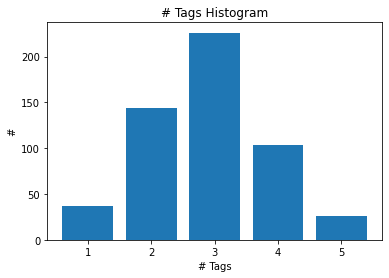

In [8]:
plt.bar(list(freq_dict.keys()), freq_dict.values())
# set the plot title and axis labels
plt.title('# Tags Histogram')
plt.xlabel('# Tags')
plt.ylabel('#')
plt.show()

In [9]:
# count unique arrays in column, considering order of elements
unique_ordered = len(set(map(tuple, df_train['tags'])))
print("Number of unique arrays in 'tags' (with order):", unique_ordered)

# count unique arrays in column, ignoring order of elements
unique_unordered = len(set(map(frozenset, df_train['tags'])))
print("Number of unique arrays in 'tags' (without order):", unique_unordered)

# we see we dont really care about the order of the tags, the have already been ordered previously

Number of unique arrays in 'tags' (with order): 207
Number of unique arrays in 'tags' (without order): 207


## Separate tags

In [10]:
def separate_tags(row):  
  max_length = 5
  none_list = [None] * max_length
  new_row = row[:max_length] + none_list[len(row):]
  return pd.Series(new_row)

In [11]:
# separate values from the arrays to a column each
tag_cols = ['tag_'+str(x) for x in range(5)]
df_train[tag_cols] = df_train['tags'].apply(separate_tags)
print(df_train.head(3))

                                                 tags              tag_0  \
701    [category-1, discounts-questions, open-ticket]         category-1   
1078  [category-1, promocode-not-working, field-1456]         category-1   
72       [where-is-my-order, open-ticket, field-1456]  where-is-my-order   

                      tag_1        tag_2 tag_3 tag_4  
701     discounts-questions  open-ticket  None  None  
1078  promocode-not-working   field-1456  None  None  
72              open-ticket   field-1456  None  None  


## Distribution tags

### Jointly

In [12]:
# distribution of all the tags jointly, meaning considering [category-1, how-to-return, None, None, None] as 1 value
df_train['tags'] = df_train['tags'].astype(str)
# df_train['tags'] = df_train.apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
tag_counts = df_train['tags'].value_counts()

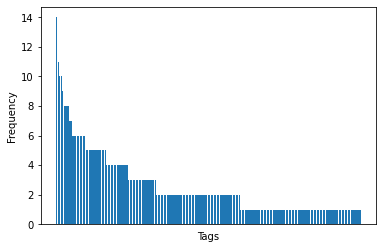

In [13]:
plt.bar(tag_counts.index, tag_counts.values)
plt.xticks([], [])
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.show()
# removed the x labels as there were too many and looked very messy

In [14]:
# we can see that there is some cases that only appear once jointly, and the top 5 most appeared are te following
print(tag_counts.nlargest(5))

['category-1', 'discounts-questions', 'open-ticket']     14
['category-1', 'exchange', 'field-1456']                 11
['category-1', 'promocode-not-working', 'field-1456']    10
['category-1', 'discounts-questions']                    10
['category-1', 'other', 'field-1456']                     9
Name: tags, dtype: int64


In [15]:
df_tags = df_train.pop('tags')

### Individually

In [16]:
def get_histogram(df):
  # extract all values and store in a list
  tags_list = df_train.stack().tolist()
  print(len(tags_list))

  # the histogram as a dictionary
  counter = Counter(tags_list)
  freq_dict = dict(counter)
  print(len(freq_dict), freq_dict)

  # dict ordered
  tag_count_ord = counter.most_common()
  return tag_count_ord, tags_list

In [17]:
tags_hist, _ = get_histogram(df_train)

1549
32 {'category-1': 346, 'discounts-questions': 59, 'open-ticket': 258, 'promocode-not-working': 61, 'field-1456': 287, 'where-is-my-order': 52, 'faulty-product': 24, 'warranty-claim-status': 22, 'donation-requests': 6, 'exchange': 57, '?': 6, 'ticket': 121, 'order-confirmation-not-received': 36, 'price-adjustment': 22, 'return-label': 21, 'return-status': 10, 'other': 49, 'wrong-item-delivered': 8, 'how-to-return': 39, 'not-a-request': 16, 'remove-item': 1, 'change-delivery-address': 10, 'change-items': 3, 'change-delivery-date': 5, 'missing-items': 6, 'warranty-policy-information': 11, 'adverse-effect': 1, 'lost-package': 5, 'cancel-subscription': 3, 'shipping-price': 2, 'cancel-order': 1, 'update-account-information': 1}


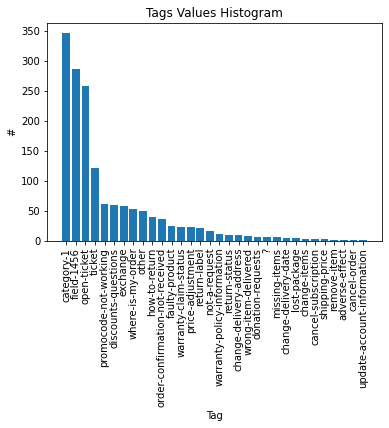

In [18]:
# plt.bar(list(freq_dict.keys()), freq_dict.values())
plt.bar([tag[0] for tag in tags_hist], [tag[1] for tag in tags_hist])
# set the plot title and axis labels
plt.title('Tags Values Histogram')
plt.xlabel('Tag')
plt.ylabel('#')
plt.xticks(rotation='vertical')
plt.show()

In [19]:
# print all the names and number
for k, v in tags_hist:
  print(k, ':', v)

category-1 : 346
field-1456 : 287
open-ticket : 258
ticket : 121
promocode-not-working : 61
discounts-questions : 59
exchange : 57
where-is-my-order : 52
other : 49
how-to-return : 39
order-confirmation-not-received : 36
faulty-product : 24
warranty-claim-status : 22
price-adjustment : 22
return-label : 21
not-a-request : 16
warranty-policy-information : 11
return-status : 10
change-delivery-address : 10
wrong-item-delivered : 8
donation-requests : 6
? : 6
missing-items : 6
change-delivery-date : 5
lost-package : 5
change-items : 3
cancel-subscription : 3
shipping-price : 2
remove-item : 1
adverse-effect : 1
cancel-order : 1
update-account-information : 1


## Replace Unknown

In [20]:
# I will replace the tags that only appear once in all the training data we have as they are very punctual
unique_tags = []
for col in df_train.columns:
    unique_tags += list(df_train[col].value_counts()[df_train[col].value_counts() == 1].index)

unique_tags = list(set(unique_tags))

# Replace the unique tags with 'Unknown'
for col in df_train.columns:
    df_train[col].replace(unique_tags, 'Unknown', inplace=True)

In [21]:
tags_hist, tags_list = get_histogram(df_train) # tags_list will be used later

1549
22 {'category-1': 346, 'discounts-questions': 59, 'open-ticket': 258, 'promocode-not-working': 61, 'field-1456': 287, 'where-is-my-order': 52, 'faulty-product': 24, 'warranty-claim-status': 22, 'donation-requests': 6, 'exchange': 57, 'Unknown': 70, 'ticket': 121, 'order-confirmation-not-received': 36, 'return-label': 21, 'other': 49, 'wrong-item-delivered': 8, 'how-to-return': 39, 'change-delivery-address': 10, 'change-delivery-date': 5, 'warranty-policy-information': 11, 'lost-package': 5, 'shipping-price': 2}


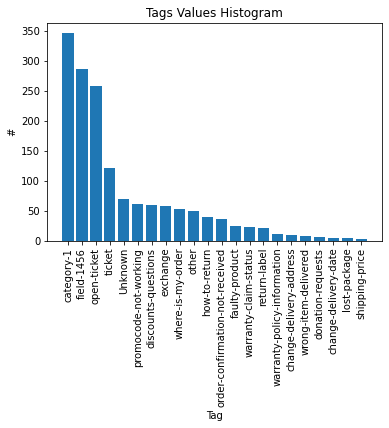

In [22]:
# plt.bar(list(freq_dict.keys()), freq_dict.values())
plt.bar([tag[0] for tag in tags_hist], [tag[1] for tag in tags_hist])
# set the plot title and axis labels
plt.title('Tags Values Histogram')
plt.xlabel('Tag')
plt.ylabel('#')
plt.xticks(rotation='vertical')
plt.show()

In [23]:
# will save the data to continue on the following section
df = pd.concat([df_train, df_text, df_labels], axis=1)
df.to_json('technical_test_data_sample_train_tags.json', indent=4)

## OneHot Encodings

In [24]:
lb = preprocessing.LabelBinarizer()
lb.fit(tags_list)
print(len(lb.classes_)) # check it found the same number of classes as I

22


In [25]:
# Save the LabelBinarizer object to a file
joblib.dump(lb, 'label_binarizer.joblib')

['label_binarizer.joblib']

In [26]:
# obtain the onehot encodigns of each value
# if its None we give a onehot encoding of [0, ..., 0]
onehot_transform = lambda x: lb.transform([x])[0] if isinstance(x, str) else np.zeros(lb.classes_.shape)
df_onehot = df_train.progress_applymap(onehot_transform)

100%|██████████| 2685/2685 [00:01<00:00, 1622.34it/s]


In [27]:
df_onehot.head(2)

,tag_0,tag_1,tag_2,tag_3,tag_4
701,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1078,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [28]:
# combine the onehots for a unique onehot
df_onehot_combined = pd.DataFrame(df_onehot.apply(lambda row: row.sum(), axis=1))
df_onehot_combined.columns = ['onehot']

In [29]:
df_onehot_combined.head(2)

,onehot
701,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
1078,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."


In [30]:
# will save the data to continue on the following section
df = pd.concat([df_onehot_combined, df_text, df_labels, df_tags], axis=1)
df.to_json('technical_test_data_sample_train_onehot.json', indent=4)

# Split Training and Eval

In [2]:
# OPTIONAL: to download the data online, to not run all the previous steps
url = 'https://raw.githubusercontent.com/lluisg/TechnicalTaskDigitalGenius/main/technical_test_data_sample_train_onehot.json'
response = requests.get(url)

json_data = response.json()
df = pd.DataFrame.from_dict(json_data)

In [3]:
# we separate the training data into training and eval with 0.8/0.2 which means a total of 0.6/0.15/0.25 for training, eval and test
train_df, eval_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

In [4]:
print('train:', train_df.shape, ', eval:', eval_df.shape)

train: (429, 4) , eval: (108, 4)


In [5]:
train_df.to_json('technical_test_data_sample_train_final.json', indent=4)
eval_df.to_json('technical_test_data_sample_eval_final.json', indent=4)

# Train the models

In [2]:
# OPTIONAL: to download the data online, to not run all the previous steps
url = 'https://raw.githubusercontent.com/lluisg/TechnicalTaskDigitalGenius/main/technical_test_data_sample_train_final.json'
response = requests.get(url)
json_data = response.json()
df_train = pd.DataFrame.from_dict(json_data)

url = 'https://raw.githubusercontent.com/lluisg/TechnicalTaskDigitalGenius/main/technical_test_data_sample_eval_final.json'
response = requests.get(url)
json_data = response.json()
df_eval = pd.DataFrame.from_dict(json_data)

In [3]:
# Separate input features (X) and labels (y)
X_train = np.array(df_train['onehot'].tolist())
y_train = np.array(df_train['labels'])

X_eval = np.array(df_eval['onehot'].tolist())
y_eval = np.array(df_eval['labels'])

In [4]:
# as I dont have much data, I will use the kfold method to train
kf = KFold(n_splits=10, shuffle=True, random_state=42)

## SVM

In [5]:
# initialize the svm model
SVM_model = svm.SVC(kernel='linear', probability=True, random_state=42)

In [6]:
scores = []
f1s = []
# Train and evaluate model using k-fold cross-validation
for train_idx, eval_idx in tqdm(kf.split(X_train), total=kf.get_n_splits(), desc="k-fold"):
    X_kf_train, X_kf_eval = X_train[train_idx], X_train[eval_idx]
    y_kf_train, y_kf_eval = y_train[train_idx], y_train[eval_idx]

    SVM_model.fit(X_kf_train, y_kf_train)
    y_pred = SVM_model.predict(X_kf_eval)

    acc = accuracy_score(y_kf_eval, y_pred) # accuracy score
    scores.append(acc)  
    f1 = f1_score(y_kf_eval, y_pred) # f1 score
    f1s.append(f1)

mean_score_svm = sum(scores) / len(scores)
f1_score_svm = sum(f1s) / len(f1s)
print('\nmean acc:', mean_score_svm, ', mean f1:', f1_score_svm)

k-fold: 100%|██████████| 10/10 [00:00<00:00, 56.56it/s]


mean acc: 0.9767441860465116 , mean f1: 0.935667033345052


### Evaluation

In [7]:
# get the predictions and confidence
y_prob = SVM_model.predict_proba(X_eval)

y_pred_svm = {}
accs = {}
precs = {}
for THRESHOLD in [0.99, 0.98, 0.97, 0.95, 0.90, 0.80, 0.70]:
  y_pred_svm[THRESHOLD] = [np.argmax(i) if np.max(i) >= THRESHOLD else 0 for i in y_prob]
  accs[THRESHOLD] = accuracy_score(y_eval, y_pred_svm[THRESHOLD]) # accuracy score
  precs[THRESHOLD] = precision_score(y_eval, y_pred_svm[THRESHOLD]) # precision score
  print('threhsold', THRESHOLD, ':', precs[THRESHOLD], 'precision,', accs[THRESHOLD], 'accuracy')

threhsold 0.99 : 0.0 precision, 0.7870370370370371 accuracy
threhsold 0.98 : 0.0 precision, 0.7870370370370371 accuracy
threhsold 0.97 : 1.0 precision, 0.9814814814814815 accuracy
threhsold 0.95 : 1.0 precision, 0.9814814814814815 accuracy
threhsold 0.9 : 1.0 precision, 0.9814814814814815 accuracy
threhsold 0.8 : 1.0 precision, 0.9814814814814815 accuracy
threhsold 0.7 : 1.0 precision, 0.9814814814814815 accuracy


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


best threshold: 0.97
acc: 0.9814814814814815 , prec: 1.0


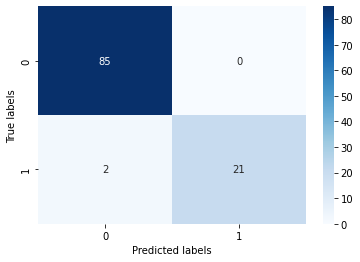

In [8]:
# the best model is the one with threshold 0.97, despite this we have one critical case
BEST_THRESH_SVM = 0.97

acc_svm = accs[BEST_THRESH_SVM]
prec_svm = precs[BEST_THRESH_SVM]

print('best threshold:', BEST_THRESH_SVM)
print('acc:', acc_svm, ', prec:', prec_svm)
sns.heatmap(confusion_matrix(y_eval, y_pred_svm[BEST_THRESH_SVM]), annot=True, cmap="Blues", fmt='g')
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

## Random Forest

In [9]:
# initialize the rf model
RF_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [10]:
scores = []
f1s = []
# Train and evaluate model using k-fold cross-validation
for train_idx, eval_idx in tqdm(kf.split(X_train), total=kf.get_n_splits(), desc="k-fold"):
    X_kf_train, X_kf_eval = X_train[train_idx], X_train[eval_idx]
    y_kf_train, y_kf_eval = y_train[train_idx], y_train[eval_idx]

    RF_model.fit(X_kf_train, y_kf_train)
    y_pred = RF_model.predict(X_kf_eval)

    acc = accuracy_score(y_kf_eval, y_pred) # accuracy score
    scores.append(acc)  
    f1 = f1_score(y_kf_eval, y_pred) # f1 score
    f1s.append(f1)

mean_score_rf = sum(scores) / len(scores)
f1_score_rf = sum(f1s) / len(f1s)
print('mean acc:', mean_score_rf, ', mean f1:', f1_score_rf)

k-fold: 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]

mean acc: 0.9627906976744185 , mean f1: 0.8812647689427873


### Evaluation

In [11]:
# get the predictions and confidence
y_prob = RF_model.predict_proba(X_eval)

y_pred_rf = {}
accs = {}
precs = {}
for THRESHOLD in [0.99, 0.98, 0.97, 0.95, 0.90, 0.80, 0.70]:
  y_pred_rf[THRESHOLD] = [np.argmax(i) if np.max(i) >= THRESHOLD else 0 for i in y_prob]
  accs[THRESHOLD] = accuracy_score(y_eval, y_pred_rf[THRESHOLD]) # accuracy score
  precs[THRESHOLD] = precision_score(y_eval, y_pred_rf[THRESHOLD]) # precision score
  print('threhsold', THRESHOLD, ':', precs[THRESHOLD], 'precision,', accs[THRESHOLD], 'accuracy')

threhsold 0.99 : 1.0 precision, 0.9074074074074074 accuracy
threhsold 0.98 : 1.0 precision, 0.9259259259259259 accuracy
threhsold 0.97 : 1.0 precision, 0.9537037037037037 accuracy
threhsold 0.95 : 1.0 precision, 0.9722222222222222 accuracy
threhsold 0.9 : 1.0 precision, 0.9814814814814815 accuracy
threhsold 0.8 : 1.0 precision, 0.9814814814814815 accuracy
threhsold 0.7 : 1.0 precision, 0.9814814814814815 accuracy


best threshold: 0.9
acc: 0.9814814814814815 , prec: 1.0


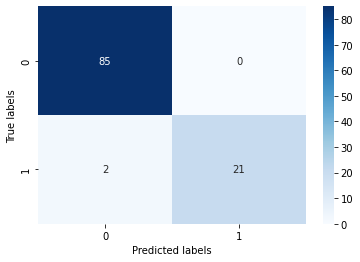

In [12]:
# the best model is the one with threshold 0.90, with maximum precision and accuracy
BEST_THRESH_RF = 0.90

acc_rf = accs[BEST_THRESH_RF]
prec_rf = precs[BEST_THRESH_RF]

print('best threshold:', BEST_THRESH_RF)
print('acc:', acc_svm, ', prec:', prec_svm)
sns.heatmap(confusion_matrix(y_eval, y_pred_rf[BEST_THRESH_RF]), annot=True, cmap="Blues", fmt='g')
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

## Neural Network

In [13]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)

X_eval_tensor = torch.tensor(X_eval, dtype=torch.float32)
y_eval_tensor = torch.tensor(y_eval, dtype=torch.float32).reshape(-1, 1)

In [14]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    print(f"Random seed set as {seed}")

set_seed(42)

Random seed set as 42


In [15]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(22, 256)
        self.relu = nn.ReLU()
        self.hidden2 = nn.Linear(256, 64)
        self.output = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.sigmoid(self.output(x))
        return x

NN_model = NeuralNetwork()

In [16]:
def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 250   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    for epoch in tqdm(range(n_epochs)):
        model.train()
        for start in batch_start:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

In [17]:
cv_scores = []
for k, (train_idx, eval_idx) in enumerate(kf.split(X_train)):
    X_kf_train, X_kf_eval = X_train_tensor[train_idx], X_train_tensor[eval_idx]
    y_kf_train, y_kf_eval = y_train_tensor[train_idx], y_train_tensor[eval_idx]

    # train model and get accuracy
    acc = model_train(NN_model, X_kf_train, y_kf_train, X_kf_eval, y_kf_eval)
    print("Accuracy kfold", k, ": %.2f" % acc)
    cv_scores.append(acc)

# evaluate the model
acc = np.mean(cv_scores)
std = np.std(cv_scores)
print("Model accuracy: %.2f%% (+/- %.2f%%)" % (acc*100, std*100))

100%|██████████| 250/250 [00:18<00:00, 13.29it/s]


Accuracy kfold 0 : 0.95


100%|██████████| 250/250 [00:17<00:00, 13.94it/s]


Accuracy kfold 1 : 0.98


100%|██████████| 250/250 [00:13<00:00, 19.00it/s]


Accuracy kfold 2 : 0.98


100%|██████████| 250/250 [00:11<00:00, 20.87it/s]


Accuracy kfold 3 : 0.98


100%|██████████| 250/250 [00:11<00:00, 21.12it/s]


Accuracy kfold 4 : 1.00


100%|██████████| 250/250 [00:11<00:00, 21.07it/s]


Accuracy kfold 5 : 0.98


100%|██████████| 250/250 [00:11<00:00, 20.97it/s]


Accuracy kfold 6 : 0.95


100%|██████████| 250/250 [00:12<00:00, 19.97it/s]


Accuracy kfold 7 : 0.98


100%|██████████| 250/250 [00:12<00:00, 19.77it/s]


Accuracy kfold 8 : 0.98


100%|██████████| 250/250 [00:11<00:00, 21.13it/s]

Accuracy kfold 9 : 1.00
Model accuracy: 97.67% (+/- 1.47%)


### Evaluation

In [18]:
# get the predictions and confidence
NN_model.eval()
with torch.no_grad():
    y_pred_NN = NN_model(X_eval_tensor)

y_pred_nn = {}
accs = {}
precs = {}
for THRESHOLD in [0.99, 0.98, 0.97, 0.95, 0.90, 0.80, 0.70]:
  y_pred_nn[THRESHOLD] = [1 if i >= THRESHOLD else 0 for i in y_pred_NN]
  accs[THRESHOLD] = accuracy_score(y_eval, y_pred_nn[THRESHOLD]) # accuracy score
  precs[THRESHOLD] = precision_score(y_eval, y_pred_nn[THRESHOLD]) # precision score
  print('threhsold', THRESHOLD, ':', precs[THRESHOLD], 'precision,', accs[THRESHOLD], 'accuracy')

threhsold 0.99 : 1.0 precision, 0.8425925925925926 accuracy
threhsold 0.98 : 1.0 precision, 0.9259259259259259 accuracy
threhsold 0.97 : 1.0 precision, 0.9537037037037037 accuracy
threhsold 0.95 : 1.0 precision, 0.9814814814814815 accuracy
threhsold 0.9 : 1.0 precision, 0.9814814814814815 accuracy
threhsold 0.8 : 1.0 precision, 0.9814814814814815 accuracy
threhsold 0.7 : 1.0 precision, 0.9814814814814815 accuracy


best threshold: 0.95
acc: 0.9814814814814815 , prec: 1.0


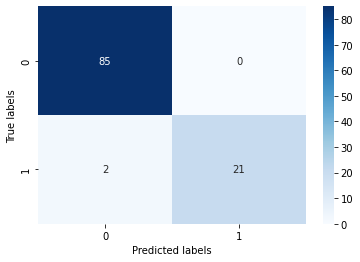

In [19]:
# the best model is the one with threshold 0.90, with maximum precision and accuracy
BEST_THRESH_NN = 0.95

acc_rf = accs[BEST_THRESH_NN]
prec_rf = precs[BEST_THRESH_NN]

print('best threshold:', BEST_THRESH_NN)
print('acc:', acc_svm, ', prec:', prec_svm)
sns.heatmap(confusion_matrix(y_eval, y_pred_nn[BEST_THRESH_NN]), annot=True, cmap="Blues", fmt='g')
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

## Save the models and Predictions

In [20]:
df_eval['SVM'] = y_pred_svm[BEST_THRESH_SVM]
df_eval['RF'] = y_pred_rf[BEST_THRESH_RF]
df_eval['NN'] = y_pred_nn[BEST_THRESH_NN]
df_eval.to_json('technical_test_data_sample_eval_predictions.json', indent=4)

In [21]:
# Save the trained models
joblib.dump(SVM_model, 'svm_model.joblib')
joblib.dump(RF_model, 'rf_model.joblib')
torch.save(NN_model.state_dict(), 'NN_model.pth')

# Visualize Error Cases Eval

In [2]:
# OPTIONAL: to download the data online, to not run all the previous steps
url = 'https://raw.githubusercontent.com/lluisg/TechnicalTaskDigitalGenius/main/technical_test_data_sample_eval_predictions.json'
response = requests.get(url)
json_data = response.json()
df_eval = pd.DataFrame.from_dict(json_data)

In [3]:
diff_svm = df_eval.index[df_eval['labels'] != df_eval['SVM']].tolist()
diff_rf = df_eval.index[df_eval['labels'] != df_eval['RF']].tolist()
diff_nn = df_eval.index[df_eval['labels'] != df_eval['NN']].tolist()

In [4]:
print('svm:', diff_svm)
print('rf:', diff_rf)
print('nn:', diff_nn)

svm: ['6', '597']
rf: ['6', '597']
nn: ['6', '597']


In [5]:
for value in ['6', '597']:
  print(value, ':')
  print(df_eval.loc[value]['text'].replace('\n', ''))
  print(df_eval.loc[value]['labels'], '->', df_eval.loc[value]['SVM'], df_eval.loc[value]['RF'], df_eval.loc[value]['NN'])
  print(df_eval.loc[value]['tags'])
  print('---------------------------------------')

6 :
hi there  i received order __ORDER_NUMBER__but are missing the 4 pairs of socks detailed on the page   please can you confirm they will be sent ?  PBSI__ITEM_PHOTO_URL     __PRODUCTS_NAMES__  GBP __AMOUNT__  Size  UK XL  Qty   2  Price  GBP __AMOUNT__ PBSI__ITEM_PHOTO_URL   __PRODUCTS_NAMES__ GBP __AMOUNT__  Size  UK XL  Qty   1  Price  GBP 20.00 PBSI__ITEM_PHOTO_URL   Mid Sock Black | Shadow  GBP 18.00  Size  UK XL  Qty   1  Price  GBP 18.00 - __EMAIL__
1 -> 0 0 0
['category-1', 'missing-items', 'field-1456']
---------------------------------------
597 :
Description:I placed an order last week for a pair of sneakers and the __PRODUCT_NAME__but I never received a confirmation email, though I did start getting your marketing emails. And second, I got an email yesterday offering a free __PRODUCT_NAMES__ with my first purchase. If I had known I would get the __PRODUCT_NAMES__ for free with my first purchase of sneakers, I wouldn't have bought one. Please let me know if my order even w

# Prepare Test data

In [6]:
# OPTIONAL: to download the data online, to not run all the previous steps
url = 'https://raw.githubusercontent.com/lluisg/TechnicalTaskDigitalGenius/main/technical_test_data_sample_test.json'
response = requests.get(url)

json_data = response.json()
df_test = pd.DataFrame.from_dict(json_data)

In [7]:
df_test = df_test.rename(columns={'Description': 'text'})
df_text = df_test.pop('text')
df_labels = df_test.pop('labels')
df_test['tags'] = df_test['tags'].apply(ast.literal_eval)

In [8]:
def separate_tags(row):  
  max_length = 5
  none_list = [None] * max_length
  new_row = row[:max_length] + none_list[len(row):]
  return pd.Series(new_row)

In [9]:
# separate values from the arrays to a column each
tag_cols = ['tag_'+str(x) for x in range(5)]
df_test[tag_cols] = df_test['tags'].apply(separate_tags)
df_tags = df_test.pop('tags')
print(df_test.head(3))

                  tag_0         tag_1        tag_2 tag_3 tag_4
65    where-is-my-order    field-1456         None  None  None
1359         category-1  return-label  open-ticket  None  None
163   where-is-my-order    field-1456         None  None  None


In [10]:
!wget https://raw.githubusercontent.com/lluisg/TechnicalTask/main/label_binarizer.joblib

--2023-03-09 15:55:44--  https://raw.githubusercontent.com/lluisg/TechnicalTask/main/label_binarizer.joblib
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3135 (3.1K) [application/octet-stream]
Saving to: ‘label_binarizer.joblib’

label_binarizer.job 100%[===================>]   3.06K  --.-KB/s    in 0s      

2023-03-09 15:55:44 (39.1 MB/s) - ‘label_binarizer.joblib’ saved [3135/3135]



In [12]:
# load the label binarizer
lb = joblib.load('label_binarizer.joblib')

In [13]:
# apply that the clases that not appeared in the training data are considered Unknown
classes = set(lb.classes_)
clas2unknown = lambda x: 'Unknown' if x not in classes and x is not None else x
df_unknown = df_test.progress_applymap(clas2unknown)

# transform to onehot encoding
onehot_transform = lambda x: lb.transform([x])[0] if isinstance(x, str) else np.zeros(lb.classes_.shape)
df_onehot = df_unknown.progress_applymap(onehot_transform)

# combine the onehots for a unique onehot
df_onehot_combined = pd.DataFrame(df_onehot.apply(lambda row: row.sum(), axis=1))
df_onehot_combined.columns = ['onehot']

100%|██████████| 895/895 [00:00<00:00, 2991.93it/s]


In [14]:
df_onehot_combined.head(2)

,onehot
65,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
1359,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [15]:
# will save the data to continue on the following section
df = pd.concat([df_onehot_combined, df_text, df_labels, df_tags], axis=1)
df.to_json('technical_test_data_sample_test_onehot.json', indent=4)

# Choose the model

### NN model

In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(22, 256)
        self.relu = nn.ReLU()
        self.hidden2 = nn.Linear(256, 64)
        self.output = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.sigmoid(self.output(x))
        return x

## Load Models

In [3]:
!wget https://raw.githubusercontent.com/lluisg/TechnicalTask/main/svm_model.joblib
!wget https://raw.githubusercontent.com/lluisg/TechnicalTask/main/rf_model.joblib
!wget https://raw.githubusercontent.com/lluisg/TechnicalTask/main/NN_model.pth

--2023-03-09 15:56:44--  https://raw.githubusercontent.com/lluisg/TechnicalTask/main/svm_model.joblib
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12827 (13K) [application/octet-stream]
Saving to: ‘svm_model.joblib’

svm_model.joblib    100%[===================>]  12.53K  --.-KB/s    in 0s      

2023-03-09 15:56:44 (69.4 MB/s) - ‘svm_model.joblib’ saved [12827/12827]

--2023-03-09 15:56:44--  https://raw.githubusercontent.com/lluisg/TechnicalTask/main/rf_model.joblib
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 458873 (448K

In [4]:
NN_model = NeuralNetwork()
NN_model.load_state_dict(torch.load('NN_model.pth'))

SVM_model = joblib.load("svm_model.joblib")
RF_model = joblib.load("rf_model.joblib")

## Evaluate on test

In [6]:
# OPTIONAL: to download the data online, to not run all the previous steps
url = 'https://raw.githubusercontent.com/lluisg/TechnicalTaskDigitalGenius/main/technical_test_data_sample_test_onehot.json'
response = requests.get(url)

json_data = response.json()
df_test = pd.DataFrame.from_dict(json_data)

In [7]:
X_test = np.array(df_test['onehot'].tolist())
y_test = np.array(df_test['labels'])

threshold: 0.97
time(s): 0.008710861206054688
acc: 0.9776536312849162 , prec: 0.96875


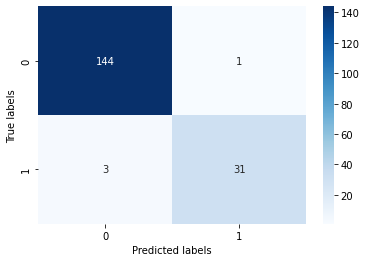

In [8]:
# results SVM
start_time = time.time()
y_prob_svm = SVM_model.predict_proba(X_test)
svm_time = time.time() - start_time

THRESHOLD_SVM = 0.97
y_pred_svm = [np.argmax(i) if np.max(i) >= THRESHOLD_SVM else 0 for i in y_prob_svm]
acc_svm = accuracy_score(y_test, y_pred_svm) # accuracy score
prec_svm = precision_score(y_test, y_pred_svm) # precision score

print('threshold:', THRESHOLD_SVM)
print('time(s):', svm_time)
print('acc:', acc_svm, ', prec:', prec_svm)
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, cmap="Blues", fmt='g')
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

threshold: 0.9
time(s): 0.02427053451538086
acc: 0.9776536312849162 , prec: 0.96875


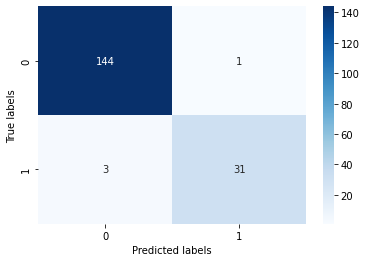

In [9]:
# results RF
# measure time taken by Random Forest to predict
start_time = time.time()
y_prob_rf = RF_model.predict_proba(X_test)
rf_time = time.time() - start_time

THRESHOLD_RF = 0.90
y_pred_rf = [np.argmax(i) if np.max(i) >= THRESHOLD_RF else 0 for i in y_prob_rf]
acc_rf = accuracy_score(y_test, y_pred_rf) # accuracy score
prec_rf = precision_score(y_test, y_pred_rf) # precision score

print('threshold:', THRESHOLD_RF)
print('time(s):', rf_time)
print('acc:', acc_rf, ', prec:', prec_rf)
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, cmap="Blues", fmt='g')
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()


threshold: 0.98
time(s): 0.0014328956604003906
acc: 0.9553072625698324 , prec: 0.9642857142857143


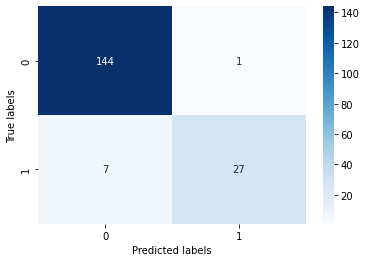

In [10]:
# results NN
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# get the predictions and confidence
NN_model.eval()
with torch.no_grad():
    start_time = time.time()
    y_pred_NN = NN_model(X_test_tensor)
    nn_time = time.time() - start_time

THRESHOLD_NN = 0.98
y_pred_nn = [1 if i >= THRESHOLD_NN else 0 for i in y_pred_NN]
acc_nn = accuracy_score(y_test, y_pred_nn) # accuracy score
prec_nn = precision_score(y_test, y_pred_nn) # precision score

print('threshold:', THRESHOLD_NN)
print('time(s):', nn_time)
print('acc:', acc_nn, ', prec:', prec_nn)
sns.heatmap(confusion_matrix(y_test, y_pred_nn), annot=True, cmap="Blues", fmt='g')
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

In [11]:
df_test['SVM'] = y_pred_svm
df_test['RF'] = y_pred_rf
df_test['NN'] = y_pred_nn
df_test.to_json('technical_test_data_sample_test_predictions.json', indent=4)

# Visualize Error Cases Test

In [2]:
# OPTIONAL: to download the data online, to not run all the previous steps
url = 'https://raw.githubusercontent.com/lluisg/TechnicalTaskDigitalGenius/main/technical_test_data_sample_test_predictions.json'
response = requests.get(url)
json_data = response.json()
df_test = pd.DataFrame.from_dict(json_data)

In [3]:
diff_svm = df_test.index[df_test['labels'] != df_test['SVM']].tolist()
diff_rf = df_test.index[df_test['labels'] != df_test['RF']].tolist()
diff_nn = df_test.index[df_test['labels'] != df_test['NN']].tolist()

In [4]:
print('svm:', diff_svm)
print('rf:', diff_rf)
print('nn:', diff_nn)

svm: ['605', '596', '67', '631']
rf: ['605', '596', '67', '631']
nn: ['605', '208', '209', '596', '54', '67', '254', '631']


In [5]:
for value in ['605', '596', '67', '631']:
  print(value, ':')
  print(df_test.loc[value]['text'].replace('\n', ''))
  print(df_test.loc[value]['labels'], '->', df_test.loc[value]['SVM'], df_test.loc[value]['RF'], df_test.loc[value]['NN'])
  print(df_test.loc[value]['tags'])
  print('---------------------------------------')

605 :
Message:Hello,   I placed an order # __ORDER_NUMBER__last week. I have two questions. First off, I thought it was wondering about the shipping of the order. I thought it was supposed to arrive by __DATE__, but I never got any shipment confirmation. Could you please advise when I could expect to receive my order?  I also saw that now the same shoes are on sale for $__AMOUNT__less. Is there a way for me to get a refund of $__AMOUNT__(as opposed to getting a new pair and returning the one that I originally purchased)?   Thank you!  __NAME__ - __EMAIL__On 01/03/11 7:07 PM, Russell Brown wrote:> Hi,> On Tue, 2011-03-01 at 18:02 +0530, Abhishek Kona wrote:>> Hi folks>>>> What is the best way to clear a Riak bucket of all key, values after>> running a test?>> I am currently using the Java HTTP API.> You can list the keys for the bucket and call delete for each. Or if you> put the keys (and kept track of them in your test) you can delete them> one at a time (without incurring the cost of